In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from collections import deque
import random
import matplotlib.pyplot as plt
import logging
import time

Load test data

In [ ]:
from LSTM_DDQN_hourly import load_and_preprocess_data

# Load test data
data_array, df, scaler = load_and_preprocess_data('C:\\Andrey\\Kakua_Projets\\Trading\\Bot_RL_v1\\Datasets\\historical_01-01-2019_to_01-01-2025_ETHUSDT.csv')

# --- Data splitting test data only ---
train_size = int(0.8 * len(data_array))
test_data = data_array[train_size:]

print(f"\nData division:")
print(f"Total: {len(data_array)}")
print(f"Evaluation: {len(test_data)}")


División de datos:
Total: 44687
Evaluación: 8938


Create agent and load trained model

In [ ]:
from LSTM_DDQN_hourly import EnhancedDQNAgent, EnhancedTradingEnvironment

# Initial configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


window_size = 24
test_env = EnhancedTradingEnvironment(test_data, window_size)
state_size = test_env.state_size
action_size = test_env.action_space
save_path = 'best_trading_model.pth'
# Initialize agent 
agent = EnhancedDQNAgent(state_size, action_size)

# Load model
agent, best_score, train_rewards = agent.load_model(save_path, device)

✅ Modelo cargado correctamente en cuda
| ε: 0.4804 | Mejor Score: -4.01% |


In [ ]:
from LSTM_DDQN_hourly import evaluate

# --- Final Evaluation---
print("\nEvaluating with test data...")
final_return, portfolio_history, price_history, actions_history = evaluate(
    agent, test_env, df, return_full_history=True
)


Evaluando con datos de test...


Metrics

In [ ]:
# Metric calculations
final_value = portfolio_history[-1]
returns = np.diff(portfolio_history) / portfolio_history[:-1]
sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(24 * 365)
max_drawdown = (np.maximum.accumulate(portfolio_history) - portfolio_history).max()
buy_hold_return = (price_history[-1] / price_history[0] - 1) * 100
actions_dist = pd.Series(actions_history).value_counts(normalize=True)
print("\n--- Final Results ---")
print(f"Initial Value: $10,000.00")
print(f"Final Value: ${final_value:,.2f}")
print(f"Strategy Return: {(final_value/10000-1)*100:.2f}%")
print(f"Buy & Hold Return: {buy_hold_return:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: ${max_drawdown:,.2f} ({max_drawdown/10000:.2%})")
print(f"Actions: Buy={actions_dist.get(2, 0):.1%}, "
        f"Sell={actions_dist.get(0, 0):.1%}, "
        f"Hold={actions_dist.get(1, 0):.1%}")



--- Resultados Finales ---
Valor inicial: $10,000.00
Valor final: $8,654.54
Retorno estrategia: -13.45%
Retorno Buy & Hold: 53.85%
Ratio de Sharpe: -0.13
Max Drawdown: $2,264.45 (22.64%)
Acciones: Comprar=16.7%, Vender=67.5%, Mantener=15.8%


Gráficos

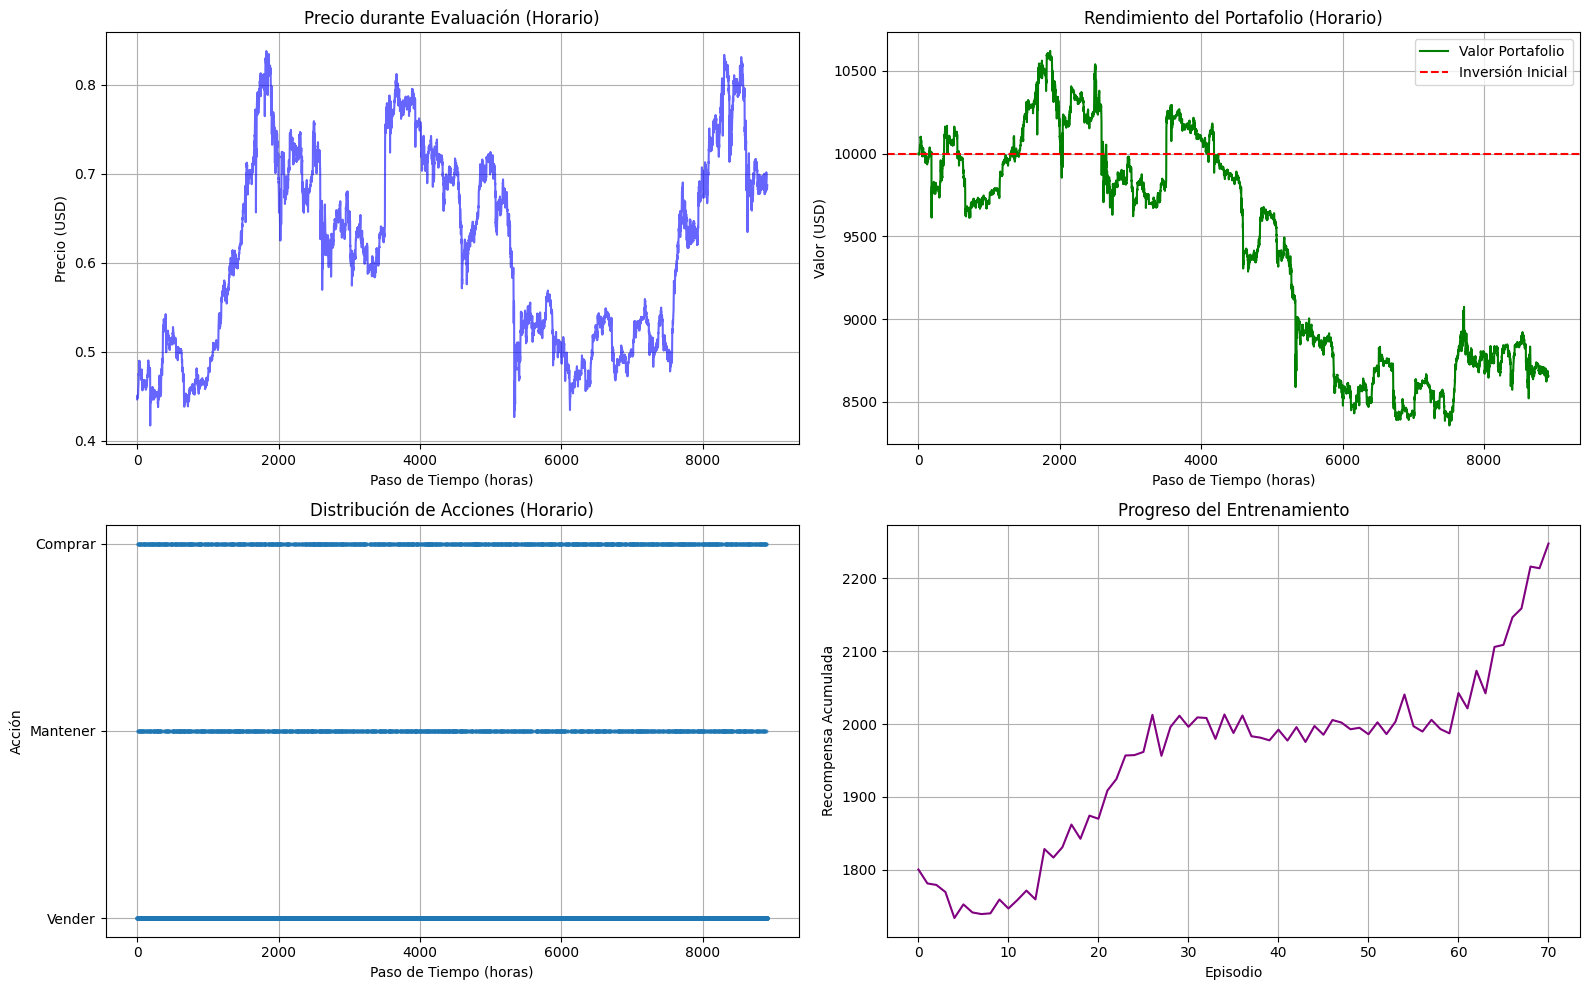

In [ ]:
# --- Visualization ---
plt.figure(figsize=(16, 10))

# Plot 1: Price
plt.subplot(2, 2, 1)
plt.plot(price_history, label='ETH Price', color='blue', alpha=0.6)
plt.xlabel('Time Step (hours)')
plt.ylabel('Price (USD)')
plt.title('Price during Evaluation')
plt.grid(True)

# Plot 2: Portfolio
plt.subplot(2, 2, 2)
plt.plot(portfolio_history, label='Portfolio Value', color='green')
plt.axhline(y=10000, color='red', linestyle='--', label='Initial Investment')
plt.xlabel('Time Step (hours)')
plt.ylabel('Value (USD)')
plt.title('Portfolio Performance')
plt.legend()
plt.grid(True)

# Plot 3: Actions
plt.subplot(2, 2, 3)
plt.plot(actions_history, 'o', markersize=2, alpha=0.6)
plt.yticks([0, 1, 2], ['Sell', 'Hold', 'Buy'])
plt.xlabel('Time Step (hours)')
plt.ylabel('Action')
plt.title('Action Distribution')
plt.grid(True)

# Plot 4: Rewards
plt.subplot(2, 2, 4)
plt.plot(train_rewards, label='Reward', color='purple')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Training Progression')
plt.grid(True)

plt.tight_layout()
plt.show()